In [1]:
# 2018-10-2
# A. Pendleton
# How many Ensembl gene models are missing in our final annotations
#    --- 500kb introns

In [2]:
#this uses iPython magic to make plots appear inline
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import sys
import numpy as np
import matplotlib.patches as patches
import gzip
import fileinput
import glob
from scipy import stats
import re
from matplotlib_venn import venn3, venn3_circles
from collections import OrderedDict
import seaborn as sns

def count_lines(f):
    lineCount = 0
    with open(f, 'r') as f:
        for line in f:
            lineCount += 1
        return lineCount
def runCMD(cmd):
    val = subprocess.Popen(cmd, shell=True).wait()
    if val == 0:
        pass
    else:
        print ('command failed')
        print (cmd)
        sys.exit(1)
# TO REMOVE TOP AND RIGHT AXIS OF PLOTS
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

### Working directory

In [3]:
wkDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Ensembl91Annotations-Canisfamiliaris/BLAT_EnsemblCDNA_ToZoey/'

### How many genes are in the Ensembl 91 CanFam3.1 annotation to begin with?

In [4]:
ensemblFasta = wkDir + '../Canis_familiaris.CanFam3.1.cds.all.fa'
geneList = []

for line in open(ensemblFasta,'r'):
    line=line.rstrip().split()
    if '>' in line[0]:
        gene = line[0].replace('>','')
        geneList.append(gene)
    else:
        continue
print('There are %i ensembl genes in the CanFam Release #91' % len(geneList))

There are 25157 ensembl genes in the CanFam Release #91


## Get CanFam Coordinates for Ensembl 91 CDS 

### PSL Format:
            1. matches - Number of bases that match that aren't repeats
            2. misMatches - Number of bases that don't match
            3. repMatches - Number of bases that match but are part of repeats
            4. nCount - Number of "N" bases
            5. qNumInsert - Number of inserts in query
            6. qBaseInsert - Number of bases inserted in query
            7. tNumInsert - Number of inserts in target
            8. tBaseInsert - Number of bases inserted in target
            9. strand - "+" or "-" for query strand. For translated alignments, second "+"or "-" is for genomic strand
            10. qName - Query sequence name
            11. qSize - Query sequence size.
            12. qStart - Alignment start position in query
            13. qEnd - Alignment end position in query
            14. tName - Target sequence name
            15. tSize - Target sequence size
            16. tStart - Alignment start position in target
            17. tEnd - Alignment end position in target
            18. blockCount - Number of blocks in the alignment (a block contains no gaps)
            19. blockSizes - Comma-separated list of sizes of each block. If the query is a protein and the target the genome, blockSizes are in amino acids. See below for more information on protein query PSLs.
            20. qStarts - Comma-separated list of starting positions of each block in query
            21. tStarts - Comma-separated list of starting positions of each block in target
            
## BED 12-column format
            1. chrom
            2. start coordinate (-1)
            3. end coordinate
            4. name - Label to be displayed under the feature, if turned on in "Configure this page".
            5. score - A score between 0 and 1000. See track lines, below, for ways to configure the display style of scored data.
            6. strand - defined as + (forward) or - (reverse).
            7. thickStart - coordinate at which to start drawing the feature as a solid rectangle
            8. thickEnd - coordinate at which to stop drawing the feature as a solid rectangle
            9. itemRgb - an RGB colour value (e.g. 0,0,255). Only used if there is a track line with the value of itemRgb set to "on" (case-insensitive).
            10. blockCount - the number of sub-elements (e.g. exons) within the feature
            11. blockSizes - the size of these sub-elements
            12. blockStarts - the start coordinate of each sub-element

In [5]:
#Where the BLAT results located:
canFamDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Ensembl91Annotations-Canisfamiliaris/BLAT_EnsemblCDNA_ToCanFam/'
blatDir = canFamDir + 'blat_results/'

canFamblatDict = {} #To store all of the results from the BLATs

#The gene sequences were split into multiple subsets to make the BLAT faster. 
#Read each blat output file (*psl) in with a loop
for file in glob.glob(blatDir + 'cds*psl'):
    for line in open(file,'r'):
        line=line.rstrip().split('\t')
        hitLength, orient, chrom, start, end = int(line[0]),line[8],line[13],int(line[14]),int(line[15])

        #gene information
        geneID, shortgeneID = line[9], line[9]
        geneLength = int(line[10])
        
        #alignment blocks
        blockLengths = line[-3].split(',')
        blocks = len(blockLengths)
        blockSumLength = 0
        for b in range(0,len(blockLengths)-1):
            blockSumLength = blockSumLength + int(blockLengths[b])
   
        #Calculate the proportion of the hit as the sum of the blocks that align
        propHit = float(blockSumLength)/geneLength
        #What type of hit is it? Full/Partial/No hit
        if propHit >= 0.9:
            hitType = 'Full'
        if propHit >= float(1/3) and propHit < 0.9:
            hitType = 'Partial'
        #Skip the genes that are not aligning with at least a third of their length
        if propHit < float(1/3):
            hitType = 'No hit'
            continue
        
        #Add to dictionary if not in there
        if shortgeneID not in canFamblatDict.keys():
            canFamblatDict[shortgeneID] = ['',propHit,chrom,start,end,geneID,orient,hitType,line]
            canFamblatDict[shortgeneID][0] = []
            #Save first hit automatically as the best hit
            topPropHit = propHit
        
        #Keep track of all proportion of hits
        canFamblatDict[shortgeneID][0].append(propHit)

        #Save it all to a dictionary
        #Redefine the top hit (topPropHit) as propHit's value since it's now a better alignment
        if propHit > topPropHit:
            topPropHit = propHit
            canFamblatDict[shortgeneID][1] = propHit
            canFamblatDict[shortgeneID][2] = chrom
            canFamblatDict[shortgeneID][3] = start
            canFamblatDict[shortgeneID][4] = end
            canFamblatDict[shortgeneID][5] = geneID
            canFamblatDict[shortgeneID][6] = orient
            canFamblatDict[shortgeneID][7] = hitType
            canFamblatDict[shortgeneID][8] = line
            #canFamblatDict[shortgeneID][9] = blocks
    
print('Added %i genes to CanFam position dictionary that at least partially hit (>1/3 of length)' % (len(canFamblatDict.keys())))
print('Done')    

Added 26099 genes to CanFam position dictionary that at least partially hit (>1/3 of length)
Done


## Parsing CanFam Ensembl 91 CDS BLAT results to Zoey2.3 assembly

In [6]:
#Where the BLAT results located:
blatDir = wkDir + 'blat_results/'

blatDict = {} #To store all of the results from the BLATs
noHitsToZoey = [] #Store the no hits to zoey2.3

#The gene sequences were split into multiple subsets to make the BLAT faster. 
#Read each blat output file (*psl) in with a loop
for file in glob.glob(blatDir + 'cds*psl'):
    for line in open(file,'r'):
        line=line.rstrip().split()
        hitLength, orient, chrom, start, end = int(line[0]),line[8],line[13],int(line[14]),int(line[15])

        #gene information
        geneID, shortgeneID = line[9], line[9]
        geneLength = int(line[10])
        
        #alignment blocks
        blockLengths = line[-3].split(',')
        blockSumLength = 0
        for b in range(0,len(blockLengths)-1):
            blockSumLength = blockSumLength + int(blockLengths[b])
   
        #Calculate the proportion of the hit as the sum of the blocks that align
        propHit = float(blockSumLength)/geneLength
        #What type of hit is it? Full/Partial/No hit
        if propHit >= 0.9:
            hitType = 'Full'
        if propHit >= float(1/3) and propHit < 0.9:
            hitType = 'Partial'
        #Skip the genes that are not aligning with at least a third of their length
        if propHit < float(1/3):
            hitType = 'No hit'
            continue
        
        #Add to dictionary if not in there
        if shortgeneID not in blatDict.keys():
            blatDict[shortgeneID] = ['',propHit,chrom,start,end,geneID,orient,hitType,line]
            blatDict[shortgeneID][0] = []
            #Save first hit automatically as the best hit
            topPropHit = propHit
        
        #Keep track of all proportion of hits
        blatDict[shortgeneID][0].append(propHit)

        #Save it all to a dictionary
        #Redefine the top hit (topPropHit) as propHit's value since it's now a better alignment
        if propHit > topPropHit:
            topPropHit = propHit
            blatDict[shortgeneID][1] = propHit
            blatDict[shortgeneID][2] = chrom
            blatDict[shortgeneID][3] = start
            blatDict[shortgeneID][4] = end
            blatDict[shortgeneID][5] = geneID
            blatDict[shortgeneID][6] = orient
            blatDict[shortgeneID][7] = hitType
            blatDict[shortgeneID][8] = line
    
    
print('Added %i genes to dictionary that at least partially hit (>1/3 of length)' % (len(blatDict.keys())))
print('Done')    

Added 26039 genes to dictionary that at least partially hit (>1/3 of length)
Done


### Make UCSC track of the canfam ensembl CDNA mapping to zoey2.3

In [11]:
## Want PSL columns: 14, 15, 16, 10, "0", 9, 15, 16, "COLOR", 18,19,20
cmd = 'mkdir -p %sUCSC_Tracks' % wkDir
print(cmd)
runCMD(cmd)

bedfile = '%sUCSC_Tracks/EnsemblCDNA_ToZoey.12.bed' % wkDir
bedFile = open(bedfile, 'w')

for gene in blatDict.keys():
    line = blatDict[gene][8]

    if blatDict[gene][7] == 'Full': ### Partial hits = black
        color = '0,0,0'
    if blatDict[gene][7] == 'Partial':  ### Partial hits = gray
        color = '128,128,128'
    if blatDict[gene][7] == 'No hit': ### Cannot place one that does not hit
        continue 
    
    #write out
    bedFile.write('%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\t%s\n' % (line[13],line[15],line[16],line[9],'0',line[8],line[15],line[16],color,line[17],line[18],line[19]))
    
bedFile.close()

#Sort the bedfile
cmd = 'sort -k1,1 -k2,2n %s > %s' % (bedfile,bedfile.replace('.bed','.sorted.bed'))
print(cmd)
runCMD(cmd)

#Convert to bigbed with bedtools
chromFile = '~/links/kidd-lab/genomes/zoey/assemblies/2.3/ref/zoey.2.3.chrom.sizes'
cmd = 'bedToBigBed %s %s %s' % (bedfile.replace('.bed','.sorted.bed'),chromFile,bedfile.replace('.bed','.sorted.bb'))
print(cmd)
runCMD(cmd)


mkdir -p /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Ensembl91Annotations-Canisfamiliaris/BLAT_EnsemblCDNA_ToZoey/UCSC_Tracks
sort -k1,1 -k2,2n /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Ensembl91Annotations-Canisfamiliaris/BLAT_EnsemblCDNA_ToZoey/UCSC_Tracks/EnsemblCDNA_ToZoey.12.bed > /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Ensembl91Annotations-Canisfamiliaris/BLAT_EnsemblCDNA_ToZoey/UCSC_Tracks/EnsemblCDNA_ToZoey.12.sorted.bed
bedToBigBed /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Ensembl91Annotations-Canisfamiliaris/BLAT_EnsemblCDNA_ToZoey/UCSC_Tracks/EnsemblCDNA_ToZoey.12.sorted.bed ~/links/kidd-lab/genomes/zoey/assemblies/2.3/ref/zoey.2.3.chrom.sizes /home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/Ensembl91Annotations-Canisfamiliaris/BLAT_EnsemblCDNA_ToZoey/UCSC_Tracks/EnsemblCDNA_ToZoey.12.sorted.bb


# Integrate all data into one dictionary

In [7]:

geneDict = {}

for gene in geneList:
    geneDict[gene] = {}

    #Get CANFAM CDS -->Zoey BLAT INFORMATION
    if gene in blatDict.keys():
        geneDict[gene]['FullGeneID'] = blatDict[gene][5]
        geneDict[gene]['Zoey_AlignmentStatus'] = blatDict[gene][7]
        geneDict[gene]['Zoey_Chrom'] = blatDict[gene][2]
        geneDict[gene]['Zoey_Start'] = blatDict[gene][3]
        geneDict[gene]['Zoey_End'] = blatDict[gene][4]
        geneDict[gene]['Zoey_PropAlign'] = blatDict[gene][1]
        geneDict[gene]['Zoey_Strand'] = blatDict[gene][2]
    else:
        geneDict[gene]['FullGeneID'] = ''
        geneDict[gene]['Zoey_AlignmentStatus'] = 'No hit'
        geneDict[gene]['Zoey_Chrom'] = ''
        geneDict[gene]['Zoey_Start'] = ''
        geneDict[gene]['Zoey_End'] = ''
        geneDict[gene]['Zoey_PropAlign'] = ''
        geneDict[gene]['Zoey_Strand'] = ''   
    
    #Get CANFAM CDS --> CANFAM BLAT INFORMATION
    if gene in canFamblatDict.keys():
        geneDict[gene]['CanFam_AlignmentStatus'] = canFamblatDict[gene][7]
        geneDict[gene]['CanFam_Chrom'] = canFamblatDict[gene][2]
        geneDict[gene]['CanFam_Start'] = canFamblatDict[gene][3]
        geneDict[gene]['CanFam_End'] = canFamblatDict[gene][4]
        geneDict[gene]['CanFam_PropAlign'] = canFamblatDict[gene][1]
        geneDict[gene]['CanFam_Strand'] = canFamblatDict[gene][2]
    else:
        geneDict[gene]['CanFam_AlignmentStatus'] = 'No hit'
        geneDict[gene]['CanFam_Chrom'] = ''
        geneDict[gene]['CanFam_Start'] = ''
        geneDict[gene]['CanFam_End'] = ''
        geneDict[gene]['CanFam_PropAlign'] = ''
        geneDict[gene]['CanFam_Strand'] = ''  

In [8]:
"""dataOrder = ['FullGeneID','Zoey_Chrom','Zoey_Start','Zoey_End','Zoey_Strand','GeneLength',
            'CanFam_AlignmentStatus','CanFam_Chrom','CanFam_Start','CanFam_End','CanFam_Strand','CanFam_PropAlign',
            'B2GO_Status','B2GO_GeneSymbol','B2GO_TopHitDesc','B2GO_HitCount','B2GO_HitEvalue','B2GO_MeanHitSimilarity',
            'B2GO_GOs','B2GO_GOsDesc','B2GO_EnzymeCode','B2GO_EnzymeCodeDesc',
            'Interpro_Domains','Interpro_GOs','Interpro_GOsDesc',
            'Kalisto_ExpressionStatus','Kalisto_LibrariesExpression']"""
dataOrder = ['FullGeneID','Zoey_AlignmentStatus','Zoey_Chrom','Zoey_Start','Zoey_End','Zoey_Strand',
            'CanFam_AlignmentStatus','CanFam_Chrom','CanFam_Start','CanFam_End','CanFam_Strand','CanFam_PropAlign']


#OUTFILE:
geneOutfile = open(wkDir + 'EnsemblGenes_HitToZoey2.3.txt','w')

#What are the headers for each column? Use array above
headerLine = []
headerLine.append('ShortGeneID')
for dataColumn in dataOrder:
    headerLine.append(dataColumn)
geneOutfile.write('\t'.join(headerLine) + '\n')
    
for gene in geneDict.keys():
    data = []
    data.append(gene)
    for dataColumn in dataOrder:
        data.append(str(geneDict[gene][dataColumn]))
    geneOutfile.write('\t'.join(data) + '\n')
    
geneOutfile.close()

# Pie chart of hits/missingness

count sum = (NoHit, Partials, Hits) (68, 215, 24874)


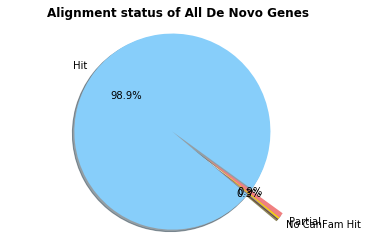

In [9]:
# BLAT TO CANFAM
NoHit, Partials, Hits = 0,0,0
for gene in geneDict.keys():    
    if geneDict[gene]['Zoey_AlignmentStatus'] == 'No hit':
        NoHit += 1
        continue
    if geneDict[gene]['Zoey_AlignmentStatus'] == 'Partial':
        Partials += 1
        continue
    if geneDict[gene]['Zoey_AlignmentStatus'] == 'Full':
        Hits += 1
        continue

    else:
        print('ERROR: What else is there?')
        print(gene,geneDict[gene])
print('count sum = (NoHit, Partials, Hits)', (NoHit, Partials, Hits))

#Make pie chart
labels = 'No CanFam Hit', 'Partial', 'Hit'
sizes = [NoHit, Partials, Hits]
colors = ['gold', 'lightcoral', 'lightskyblue']
explode = (0, 0, 0.4)  # explode 1st slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=320)
plt.title('Alignment status of All De Novo Genes', fontweight='bold') 
plt.axis('equal')
plt.show()

## What genes are missing?

In [10]:
for gene in geneDict.keys():    
    if geneDict[gene]['Zoey_AlignmentStatus'] == 'No hit' and geneDict[gene]['CanFam_Chrom'] != '':
        print('%s\t%s:%i-%i\n'%(str(gene),str(geneDict[gene]['CanFam_Chrom']),int(geneDict[gene]['CanFam_Start']),int(geneDict[gene]['CanFam_End'])))
        

ENSCAFT00000037367.2	chrUn:83971564-71295284

ENSCAFT00000023044.3	chrUn:83971564-71294268

ENSCAFT00000037896.2	chrUn:83971564-23042744

ENSCAFT00000009695.2	chr21:50858623-26733314

ENSCAFT00000049067.1	chr21:50858623-44542118

ENSCAFT00000043311.1	chr7:80974532-80967386

ENSCAFT00000047259.1	chrUn:83971564-4075220

ENSCAFT00000046784.1	chrX:123869142-44845510

ENSCAFT00000045059.2	chrUn:83971564-12495146

ENSCAFT00000046285.1	chr3:91889043-11492173

ENSCAFT00000044771.1	chrUn:83971564-18786854

ENSCAFT00000048737.1	chrUn:83971564-66092001

ENSCAFT00000025548.3	chr4:88276631-34817305

ENSCAFT00000043634.1	chrUn:83971564-23677823

ENSCAFT00000038338.2	chrUn:83971564-65458449

ENSCAFT00000048789.2	chr18:55844845-45137691

ENSCAFT00000020445.1	chr38:23914537-21268000

ENSCAFT00000020426.3	chr38:23914537-21270891

ENSCAFT00000039621.3	chrUn:83971564-3420314

ENSCAFT00000038678.2	chr21:50858623-26751557

ENSCAFT00000043198.1	chrX:123869142-72309822

ENSCAFT00000044429.1	chr5:88915250-3861

# What chromosomes are the missing genes found on?

In [11]:
nohit_chroms = []

for gene in geneDict.keys():    
    if geneDict[gene]['Zoey_AlignmentStatus'] == 'No hit':
        nohit_chroms.append(geneDict[gene]['CanFam_Chrom'])

for chrom in list(set(nohit_chroms)):
    print(chrom,nohit_chroms.count(chrom))

 7
chrUn 31
chr21 3
chr15 1
chr11 1
chr4 1
chr18 1
chr7 2
chr27 1
chr32 1
chrX 4
chr26 1
chr38 3
chr35 1
chr17 3
chr2 4
chr5 1
chr3 1
chr34 1


In [12]:
#Dictionary of Zoey genes
# 100kb
#WRONG- finalZoeyCDS = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/rna-seq/NonRedundant_NoRMIntersect_FilteredGeneSet/TotalSet_NoRMSingleExons_AllMultiExons_cds.fa'
# 500kb: 
finalZoeyCDS = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/FINAL_GENES/Zoey_FinalGenes.cds.fa'

ZOEYgeneDict = {}
ZOEYgeneList = []

for line in open(finalZoeyCDS,'r'):
    if '>' not in line: #only want identifer
        continue
    line=line.rstrip().replace('>','')
    shortID = line.split('::')[1]
    ZOEYgeneDict[shortID] = []
    ZOEYgeneList.append(shortID)

print('%i Zoey final gene models added to dictionary' % len(ZOEYgeneList))


42911 Zoey final gene models added to dictionary
